# How to apply optimal QAOA transpilation with a StagedPassManager and AnnotatedQAOAAnsatz

This tutorial shows how applying domain-specific transpilation strategies allows to reduce circuit depth and 2-qubit gate count on qaoa circuits.

References:

[1] Sack, S. H., & Egger, D. J. (2023). Large-scale quantum approximate optimization on non-planar graphs with machine learning noise mitigation. arXiv preprint arXiv:2307.14427.

[2] Weidenfeller, J., Valor, L. C., Gacon, J., Tornow, C., Bello, L., Woerner, S., & Egger, D. J. (2022). Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware. Quantum, 6, 870. 

## Problem setting

We'll start our workflow with a graph that represents a hypothetical max-cut problem, for example:

In [1]:
from networkx import barabasi_albert_graph, draw

graph = barabasi_albert_graph(n=10, m=6, seed=42)

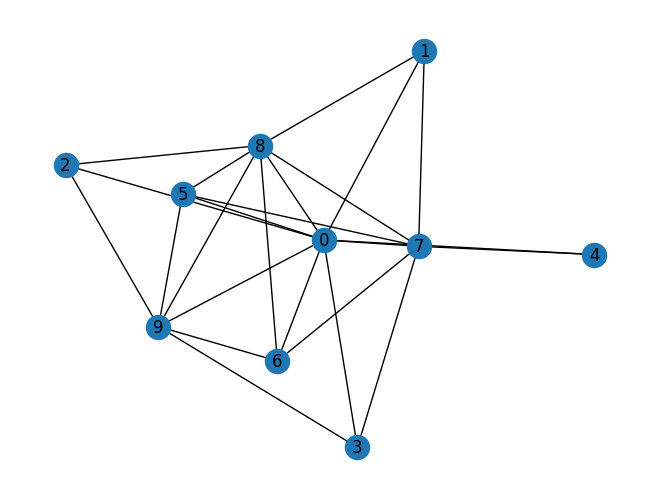

In [2]:
draw(graph, with_labels=True)

The graph above corresponds to the following operator.

In [3]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIZIIIIIZI', 'IZIIIIIIZI', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIZIIIZIII', 'ZIIIIIZIII', 'IIZIIZIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [4]:
# import json

# graph_file = "data/graph_2layers_0seed.json"
# data = json.load(open(graph_file, "r"))

# local_correlators = data["paulis"]
# print(local_correlators)
# cost_operator = SparsePauliOp.from_list(local_correlators)

This operator maps to a 10 qubit QAOA circuit:

In [5]:
num_qubits = cost_operator.num_qubits
print(num_qubits)

10


And we'll fix the number of QAOA layers to 3 for both workflows:

In [6]:
qaoa_layers = 3

We can design a fake backend with the same basis gates and connectivity as "ibm_torino" but smaller number of qubits that will allow us to perform a statevector simulation:

In [7]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
print(cmap.size())
backend = GenericBackendV2(
    num_qubits=19, coupling_map=cmap, basis_gates=["x", "sx", "cz", "id", "rz"], seed=0
)

19


Now, let's look at a naive workflow using exclusively transpilation defaults:

## Naive QAOA Workflow

Build QAOA circuit/ansatz:

In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import qaoa_ansatz
from qiskit.circuit import ParameterVector

# Use off-the-shelf qiskit qaoa_ansatz
qaoa_circuit = qaoa_ansatz(cost_operator, reps=qaoa_layers)
qaoa_circuit.measure_all()

Let's inspect the default pass manager for optimization level 3:

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

The pass contains the following stages:

In [10]:
print(naive_pm.expanded_stages)

('pre_init', 'init', 'post_init', 'pre_layout', 'layout', 'post_layout', 'pre_routing', 'routing', 'post_routing', 'pre_translation', 'translation', 'post_translation', 'pre_optimization', 'optimization', 'post_optimization', 'pre_scheduling', 'scheduling', 'post_scheduling')


In [11]:
# naive_pm.draw()

And the following passes per stage:

In [12]:
print("init")
for task in naive_pm.init._tasks:
    print(task)

print("----")
print("layout")
for task in naive_pm.layout._tasks:
    print(task)

print("----")
print("routing")
for task in naive_pm.routing._tasks:
    print(task)

print("----")
print("translation")
for task in naive_pm.translation._tasks:
    print(task)

print("----")
print("optimization")
for task in naive_pm.optimization._tasks:
    print(task)

print("----")
print("scheduling")
for task in naive_pm.scheduling._tasks:
    print(task)

init
[<qiskit.transpiler.passes.optimization.remove_diagonal_gates_before_measure.RemoveDiagonalGatesBeforeMeasure object at 0x11166a090>, <qiskit.transpiler.passes.optimization.remove_identity_equiv.RemoveIdentityEquivalent object at 0x11166a210>, <qiskit.transpiler.passes.optimization.inverse_cancellation.InverseCancellation object at 0x11166a350>, <qiskit.transpiler.passes.optimization.contract_idle_wires_in_control_flow.ContractIdleWiresInControlFlow object at 0x11166a4d0>]
----
layout
----
routing
----
translation
[<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis object at 0x111677310>, <qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x1107fba90>, <qiskit.transpiler.passes.basis.basis_translator.BasisTranslator object at 0x11163c6d0>]
----
optimization
[<qiskit.transpiler.passes.analysis.depth.Depth object at 0x111693490>, <qiskit.transpiler.passes.analysis.size.Size object at 0x111693550>, <qiskit.transpiler.passes.utils

Let's use it to transpile the circuit:

In [13]:
def callback_func(**kwargs):
    pass_ = kwargs["pass_"]
    print(pass_)

In [14]:
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
naively_transpiled_qaoa = naive_pm.run(qaoa_circuit)
t1 = time.time()

In [15]:
print(f"transpilation time: {t1 - t0} (s)")

transpilation time: 0.36084604263305664 (s)


In [16]:
naively_transpiled_qaoa.count_ops()

OrderedDict([('sx', 665),
             ('rz', 537),
             ('cz', 359),
             ('measure', 10),
             ('x', 8),
             ('barrier', 1)])

In [17]:
naively_transpiled_qaoa.depth()

760

Let's look at a domain-specific transpialation workflow and see how the transpilation time, total number of 2q gates and circuit depth compares to the default pipeline.

## Optimal QAOA Transpilation Workflow with Annotated Ansatz

The optimal QAOA workflow consists on the following steps:

1. We start off by only building an annotated ansatz, where the initial state, cost layer and mixer layer are annotated to identify type of block and layer number
2. We define a pass manager with transpiler passes that apply specific swap strategies as per [1,2] to the cost layer, as well as synthesis and cancellation passes
4. Once the layer-specific transpilation steps are completed, we use the `UnrollBoxes` pass to remove the box structure and allow our ansatz to behave like any standard quantum circuit
5. With the circuit unrolled, we translate it to the hardware native gates and route it to the optimal qubit layout through backend evaluation as per [2]

**What's interesting about this workflow is that we can embed it fully in a custom staged pass manager and define passes that act upon specific boxes depending on the annotation.** 

### 1. Build annotated ansatz

Here is a single layer example of how an annotated ansatz looks like. You will notice the boxes that mark different blocks:

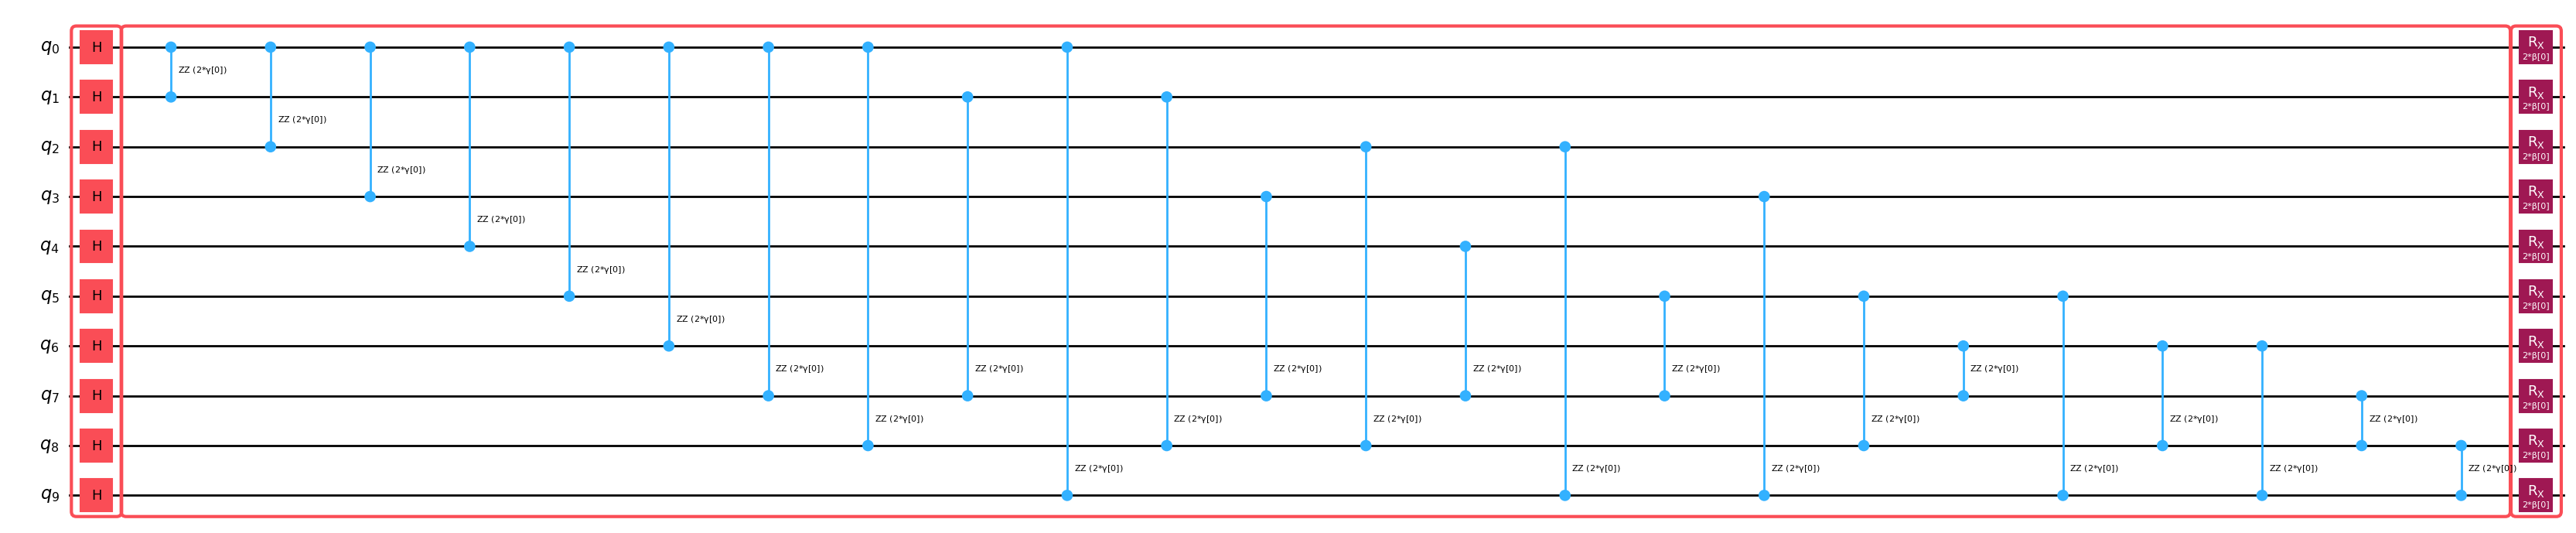

In [18]:
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

dummy_ansatz = annotated_qaoa_ansatz(cost_operator, reps=1)
dummy_ansatz.draw("mpl", fold=-1)

With this structure, we can iterate over the boxes and define behaviors depending on the annotations:

In [19]:
for instr in dummy_ansatz.data:
    print("This instruction is of type:", instr.operation.name)
    print("The type of layer is:", instr.operation.annotations[0].namespace)
    print("The layer number is:", instr.operation.annotations[0].payload)

This instruction is of type: box
The type of layer is: qaoa.init_state
The layer number is: 1
This instruction is of type: box
The type of layer is: qaoa.cost_layer
The layer number is: 1
This instruction is of type: box
The type of layer is: qaoa.mixer
The layer number is: 1


Let's look at the full ansatz now:

In [20]:
from qopt_best_practices.circuit_library import annotated_qaoa_ansatz

annotated_ansatz = annotated_qaoa_ansatz(cost_operator, reps=qaoa_layers)
annotated_ansatz.draw("mpl", fold=-1)
annotated_ansatz.measure_all()

In [21]:
for instr in annotated_ansatz.data:
    if not instr.operation.name in ["barrier", "measure"]:
        print("This instruction is of type:", instr.operation.name)
        print("The type of layer is:", instr.operation.annotations[0].namespace)
        print("The layer number is:", instr.operation.annotations[0].payload)

This instruction is of type: box
The type of layer is: qaoa.init_state
The layer number is: 1
This instruction is of type: box
The type of layer is: qaoa.cost_layer
The layer number is: 1
This instruction is of type: box
The type of layer is: qaoa.mixer
The layer number is: 1
This instruction is of type: box
The type of layer is: qaoa.cost_layer
The layer number is: 2
This instruction is of type: box
The type of layer is: qaoa.mixer
The layer number is: 2
This instruction is of type: box
The type of layer is: qaoa.cost_layer
The layer number is: 3
This instruction is of type: box
The type of layer is: qaoa.mixer
The layer number is: 3


### 2. Design pass manager for cost layer transpilation

The cost layer transpilation stage will apply the swap strategies from [1,2] to optimally route the cost layer circuit into the connectivity of our backend. This collection of passes will insert swap gates to fit the circuit to the chip connectivity in a way that will allow to maximally cancel CNOT gates and reduce the total circuit depth.

Note that we are routing the circuit into a `line`, which proves to be optimal in most QAOA cases. To make sure that the line fits into our chip, we use the `BackendEvaluator` utility before committing to the swap strategy:

In [22]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)
print(path, fidelity)

[2, 14, 1, 13, 0, 9, 3, 15, 11, 17] 0.9819974970192988


The collection of passes defined below will be embedded into the "pre_init" stage of our `StagedPassManager`.

In [23]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
)

from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
)

from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit.circuit.library import CXGate

from qopt_best_practices.transpilation import (
    AnnotatedPrepareCostLayer,
    AnnotatedCommuting2qGateRouter,
    AnnotatedSwapToFinalMapping,
    SynthesizeAndSimplifyCostLayer,
    UnrollBoxes,
)

We need to signal to the transpiler that the gates in the QAOA cost layer all commute with each other. This is done by wrapping them in a special `Commuting2qBlock` circuit instruction. This instruction is picked-up by the transpiler pass that implements the swap network.

In [24]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define pass manager for annotated qaoa ansatz
pre_init = PassManager(
    [
        AnnotatedPrepareCostLayer(),
        AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring),
        AnnotatedSwapToFinalMapping(),
        SynthesizeAndSimplifyCostLayer(basis_gates=["x", "cx", "sx", "rz", "id"]),
        UnrollBoxes(),
    ]
)

We can run this pass manager independently to confirm that it performs the desired transformations:

OrderedDict([('measure', 10), ('box', 7), ('barrier', 1)])


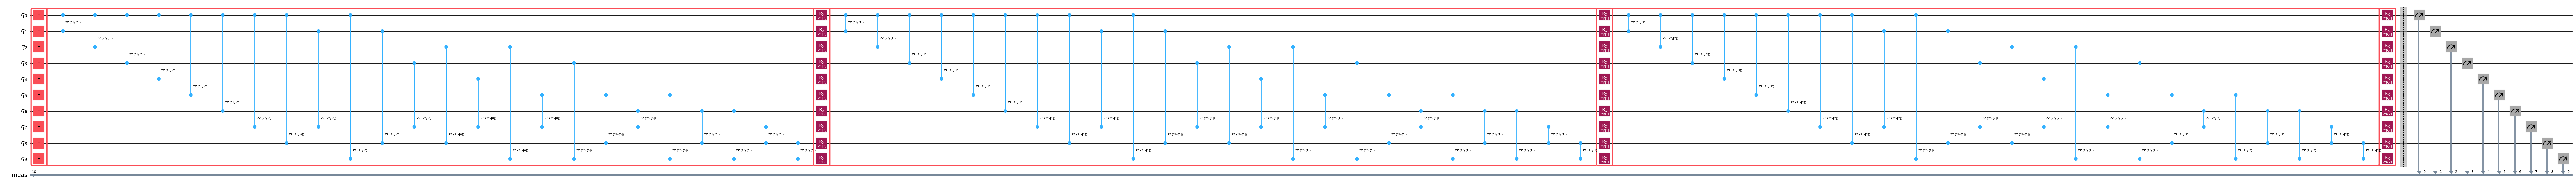

In [25]:
# Before:
print(annotated_ansatz.count_ops())
annotated_ansatz.draw("mpl", fold=-1)

In [26]:
tmp = pre_init.run(annotated_ansatz)

OrderedDict([('cx', 333), ('rz', 72), ('rx', 30), ('h', 10), ('measure', 10), ('barrier', 1)])


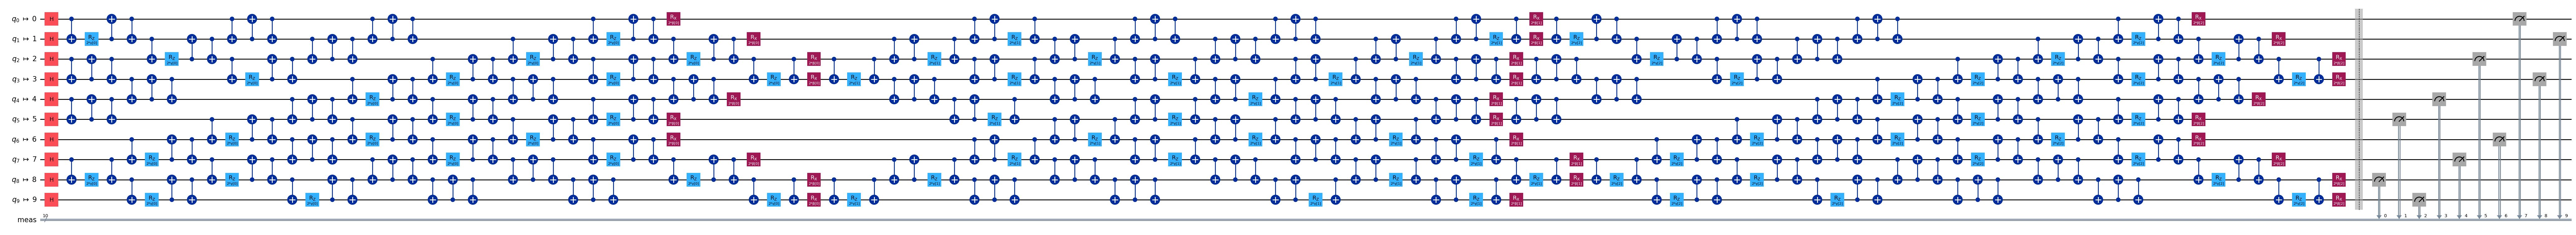

In [27]:
# After:
print(tmp.count_ops())
tmp.draw("mpl", fold=-1)

### 3. Complete the pipeline

Now that we can optimize the cost layer of our QAOA ansatz, we need to fill out the remaining stages of the pipeline. We can use as a reference the output of the preset pass manager and just replace the init, pre-init and post-init stages with our custom pass managers. We will have to define a "post_init" step that takes care of the basis translation part to match the expected output in the default pipeline.

In [28]:
from qiskit.transpiler import Layout

# We use the obtained path to define the initial layout
initial_layout = Layout.from_intlist(path, annotated_ansatz.qregs[0])

In [29]:
# The post init step unrolls the gates in the ansatz to the backend basis gates
post_init = PassManager(
    [
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names, min_qubits=3),
        BasisTranslator(_sel, target_basis=backend.operation_names, min_qubits=3),
    ]
)

In [30]:
staged_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
staged_pm.pre_init = pre_init
staged_pm.post_init = post_init
# staged_pm.routing = None

In [31]:
print("pre_init")
for task in staged_pm.pre_init._tasks:
    print(task)

print("----")
print("init")
for task in staged_pm.init._tasks:
    print(task)

print("----")
print("post_init")
for task in staged_pm.post_init._tasks:
    print(task)

print("----")
print("layout")
for task in staged_pm.layout._tasks:
    print(task)

print("----")
print("optimization")
for task in staged_pm.optimization._tasks:
    print(task)

print("----")
print("routing")
for task in staged_pm.routing._tasks:
    print(task)

pre_init
[<qopt_best_practices.transpilation.annotated_transpilation_passes.AnnotatedPrepareCostLayer object at 0x111b553d0>, <qopt_best_practices.transpilation.annotated_transpilation_passes.AnnotatedCommuting2qGateRouter object at 0x111a580d0>, <qopt_best_practices.transpilation.annotated_transpilation_passes.AnnotatedSwapToFinalMapping object at 0x111c7c450>, <qopt_best_practices.transpilation.annotated_transpilation_passes.SynthesizeAndSimplifyCostLayer object at 0x111cbcb10>, <qopt_best_practices.transpilation.annotated_transpilation_passes.UnrollBoxes object at 0x111c630d0>]
----
init
[<qiskit.transpiler.passes.optimization.remove_diagonal_gates_before_measure.RemoveDiagonalGatesBeforeMeasure object at 0x118057dd0>, <qiskit.transpiler.passes.optimization.remove_identity_equiv.RemoveIdentityEquivalent object at 0x118018b90>, <qiskit.transpiler.passes.optimization.inverse_cancellation.InverseCancellation object at 0x1180560d0>, <qiskit.transpiler.passes.optimization.contract_idle_w

### 4. Run the StagedPassManager

In [32]:
t0_opt = time.time()
optimally_transpiled_qaoa = staged_pm.run(annotated_ansatz)
t1_opt = time.time()

## Comparison between naive and optimal

In [33]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 359
2q gate count for optimal circuit = 333


In [34]:
naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(
    filter_function=lambda x: x.operation.name == "cz"
)

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth}")

2q depth for naive circuit = 241
2q depth for optimal circuit = 84


In [35]:
naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth}")

total depth for naive circuit = 760
total depth for optimal circuit = 295


In [36]:
time_naive = t1 - t0
time_optimal = t1_opt - t0_opt

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")

total time for naive transpilation = 0.36084604263305664 (s)
total time for optimal transpilation = 0.22186279296875 (s)


In [37]:
# optimally_transpiled_qaoa.draw(fold=-1)

In [38]:
# naively_transpiled_qaoa.draw(fold=-1)

## Stripping down the pipeline

In [39]:
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
    CommutativeCancellation,
)

# The post init step unrolls the gates in the ansatz to the backend basis gates
post_init = PassManager(
    [
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names),
        BasisTranslator(_sel, target_basis=backend.operation_names),
    ]
)

# The layout step applies the previously computed layout and enlarges the circuit
# with ancilla qubits to have the same number of physical qubits as the target
layout = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend.target),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# The optimization step performs additional gate cancellations
optimization = PassManager([CommutativeCancellation(target=backend.target)])

from qiskit.transpiler import StagedPassManager

other_staged_pm = StagedPassManager(
    stages=["init", "layout", "optimization"],
    pre_init=pre_init,
    post_init=post_init,
    layout=layout,
    optimization=optimization,
)

In [40]:
t0_opt = time.time()
optimally_transpiled_qaoa = other_staged_pm.run(annotated_ansatz)
t1_opt = time.time()

In [41]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 359
2q gate count for optimal circuit = 333


In [42]:
naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(
    filter_function=lambda x: x.operation.name == "cz"
)

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth}")

2q depth for naive circuit = 241
2q depth for optimal circuit = 84


In [43]:
naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth}")

total depth for naive circuit = 760
total depth for optimal circuit = 313


In [44]:
time_naive = t1 - t0
time_optimal = t1_opt - t0_opt

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")

total time for naive transpilation = 0.36084604263305664 (s)
total time for optimal transpilation = 0.06311988830566406 (s)
